In [ ]:
import os
import cv2

import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from moviepy.editor import *

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


In [ ]:
! wget https://www.crcv.ucf.edu/data/UCF101/UCF101.rar --no-check-certificate



--2024-12-15 20:22:45--  https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 6932971618 (6.5G) [application/x-rar-compressed]
Saving to: ‘UCF101.rar.1’

UCF101.rar.1        100%[===================>]   6.46G  45.7MB/s    in 2m 33s  

2024-12-15 20:25:18 (43.3 MB/s) - ‘UCF101.rar.1’ saved [6932971618/6932971618]



In [ ]:
! unrar x UCF101.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from UCF101.rar


Would you like to replace the existing file UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi
294566 bytes, modified on 2012-10-01 08:15
with a new one
294566 bytes, modified on 2012-10-01 08:15

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit 
User break

User break


In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)


In [ ]:
#math plotlib figure ans specify the size of figure
plt.figure(figsize = (20,20))

all_classes_names = os.listdir('UCF-101')

random_range = random.sample(range(len(all_classes_names)),20)


<Figure size 2000x2000 with 0 Axes>

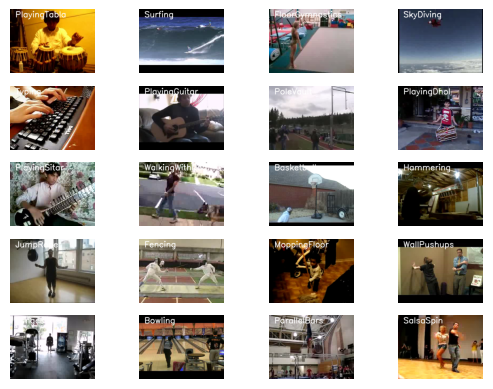

In [ ]:
for counter, random_index in enumerate(random_range, 1):
  selected_class_name = all_classes_names[random_index]
  video_files_names_list = os.listdir(f'UCF-101/{selected_class_name}')

  selected_video_file_name = random.choice(video_files_names_list)
  video_reader = cv2.VideoCapture(f'UCF-101/{selected_class_name}/{selected_video_file_name}')

  _, bgr_frame = video_reader.read()

  video_reader.release()

  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  cv2.putText(rgb_frame, selected_class_name, (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
  plt.subplot(5, 4, counter);plt.imshow(rgb_frame); plt.axis('off')




#Process data phase

In [ ]:
image_height, image_width = 64,62

sequence_length = 20

data_dir = "UCF-101"

classes_list = ["ApplyEyeMakeup", "Biking", "BabyCrawling", "BrushingTeeth", "Swing"]


In [ ]:
def frames_extraction(video_path):
  #Declare a list to store video frames.
  frames_list = []

  video_reader = cv2.VideoCapture(video_path)

  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_frames_window = max(int(video_frames_count/sequence_length), 1)

  for frame_counter in range(sequence_length):

    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter* skip_frames_window)

    success, frame = video_reader.read()

    if not success:
      break
    resized_frame = cv2.resize(frame,(image_height, image_width))

    normalized_frame = resized_frame / 255

    frames_list.append(normalized_frame)

  video_reader.release()

  return frames_list


In [ ]:
def create_dataset():

  features = []
  labels = []
  video_files_paths = []

  for class_index, class_name in enumerate(classes_list):

    print(f'Extracting Data of Class: {class_name}')

    files_list = os.listdir(os.path.join(data_dir,class_name ))

    for file_name in files_list:

      video_file_path = os.path.join(data_dir, class_name, file_name)

      frames = frames_extraction(video_file_path)

      if len(frames) == sequence_length:

        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)
  #Converting the list to nimpy arrays
  features = np.asarray(features)
  labels = np.array(labels)
  return features, labels, video_files_paths




###Create our dataset

In [ ]:
features, labels, video_files_paths = create_dataset()


Extracting Data of Class: ApplyEyeMakeup
Extracting Data of Class: Biking
Extracting Data of Class: BabyCrawling
Extracting Data of Class: BrushingTeeth
Extracting Data of Class: Swing


###Convert labels into one-hot encoded vectors

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                             test_size = 0.25, shuffle = True,
                                                                             random_state = seed_constant)

In [ ]:
def create_convlstm_model():

  model = Sequential()

  model.add(ConvLSTM2D(filters = 4, kernel_size = (3,3), activation = "tanh", data_format = "channels_last",
            recurrent_dropout = 0.2, return_sequences = True, input_shape = (sequence_length, image_height, image_width, 3)))
  model.add(MaxPooling3D(pool_size = (1,2,2), padding = "same", data_format = "channels_last" ))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 8, kernel_size = (3,3), activation = "tanh", data_format = "channels_last",
            recurrent_dropout = 0.2, return_sequences = True, input_shape = (sequence_length, image_height, image_width, 3)))
  model.add(MaxPooling3D(pool_size = (1,2,2), padding = "same", data_format = "channels_last" ))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 14, kernel_size = (3,3), activation = "tanh", data_format = "channels_last",
            recurrent_dropout = 0.2, return_sequences = True, input_shape = (sequence_length, image_height, image_width, 3)))
  model.add(MaxPooling3D(pool_size = (1,2,2), padding = "same", data_format = "channels_last" ))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 16, kernel_size = (3,3), activation = "tanh", data_format = "channels_last",
            recurrent_dropout = 0.2, return_sequences = True, input_shape = (sequence_length, image_height, image_width, 3)))
  model.add(MaxPooling3D(pool_size = (1,2,2), padding = "same", data_format = "channels_last" ))
  #model.add(TimeDistributed(Dropout(0.2)))

  model.add(Flatten())
  model.add(Dense(len(classes_list), activation = "softmax"))
  model.summary()
  return model


In [ ]:
convlstm_model = create_convlstm_model()

  super().__init__(**kwargs)



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)           │ (None, 20, 62, 60, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 20, 31, 30, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 20, 31, 30, 4)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)           │ (None, 20, 29, 28, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 20, 15, 14, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 20, 15, 14, 8)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_6 (ConvLSTM2D)           │ (None, 20, 13, 12, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 20, 7, 6, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 20, 7, 6, 14)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)           │ (None, 20, 5, 4, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 20, 3, 2, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           9,605 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,605 (166.43 KB)

 Trainable params: 42,605 (166.43 KB)

 Non-trainable params: 0 (0.00 B)

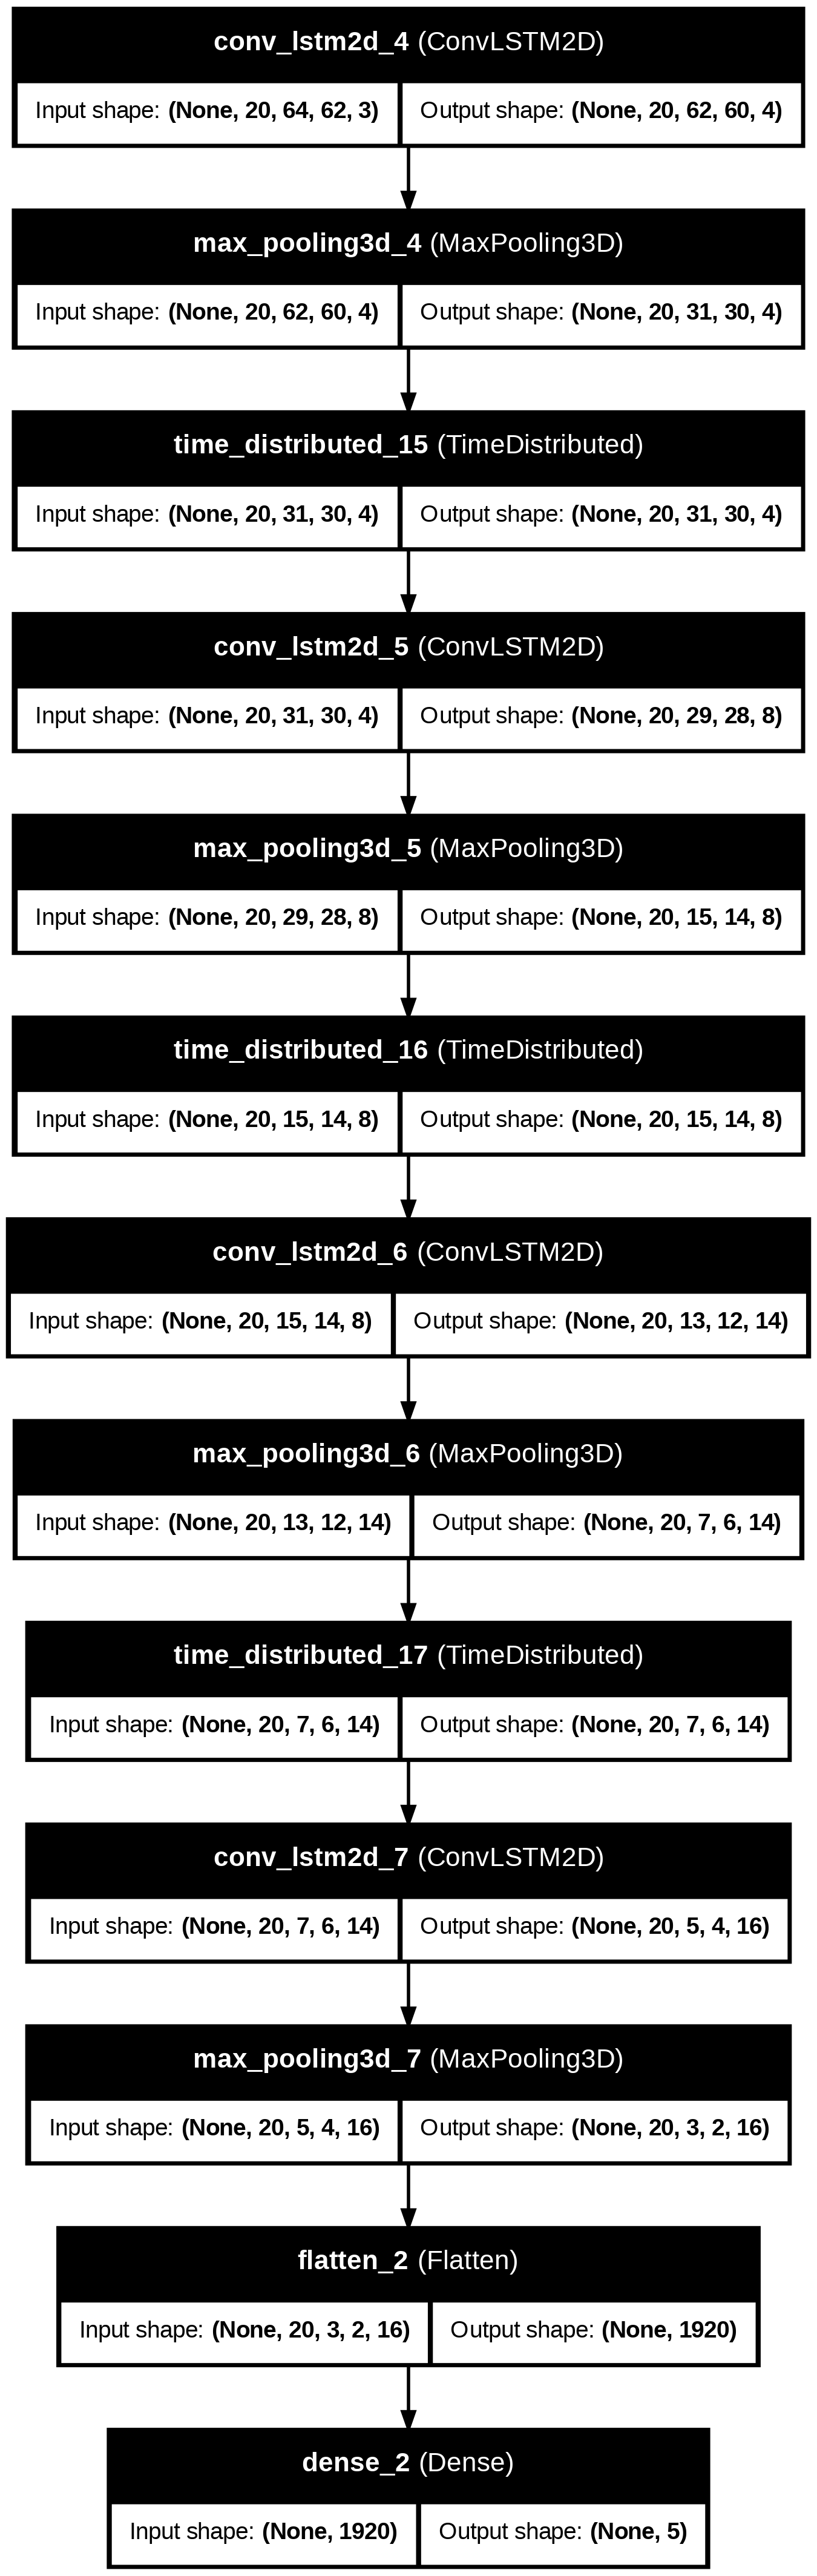

In [ ]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# An example of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
#Compile Model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
#Training the model
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 10, batch_size = 5,
                                                     shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/10


ValueError: Exception encountered when calling ConvLSTM2D.call().

[1mInput 0 of layer "conv_lstm_cell" is incompatible with the layer: expected shape=(None, 64, 62, 3), found shape=(None, 62, 64, 3)[0m

Arguments received by ConvLSTM2D.call():
  • sequences=tf.Tensor(shape=(None, 20, 62, 64, 3), dtype=float32)
  • initial_state=None
  • mask=None
  • training=True

In [ ]:
#Evaluate and Train model
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

In [ ]:
#save the model
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
date_time_format = '%Y_%m_%d__%H_%s'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt,date_time_format)

model_file_name = f'covlstm_mode__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

In [ ]:
def creat_LRCN_model():
  model = Sequential()

  model.add(TimeDistributed(Conv2D(16,(3,3), padding = 'same', activation = 'relu'),
                            input_shape = (sequence_length, image_height, image_width,3)))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32,(3,3), padding = 'same', activation = 'relu'),
                            input_shape = (sequence_length, image_height, image_width,3)))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3), padding = 'same', activation = 'relu'),
                            input_shape = (sequence_length, image_height, image_width,3)))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3), padding = 'same', activation = 'relu'),
                            input_shape = (sequence_length, image_height, image_width,3)))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  #model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(Dense(len(classes_list), activation = 'softmax'))
  model.summary()

  return model


In [ ]:
  LRCN_model = creat_LRCN_model()

In [ ]:
#plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
#Compile and Train the Model

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train,epochs = 30, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])


In [ ]:
#Evaluate the trained model

model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

In [ ]:
#Save the model
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format )
model_file_name = f'LRCN_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  plt.title(str(plot_name))
  plt.legend()

In [ ]:

plot_metric(LRCN_model_training_history, 'loss','val_loss', 'Total loss vs Total validation loss', )

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total accuracy vs Total validation accuracy')